**Defensive Portfolio - Jupyter Notebook, Python 3.12.1, September 2024**

In [29]:
import yfinance as yf
import pandas as pd
import ffn as ffn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import kurtosis, skew
import warnings
warnings.filterwarnings('ignore')

In [30]:
sp_data = yf.download('^SP500TR', start='1990-01-01', end='2024-09-18')

gold_spot = pd.read_csv('data/gold_prices.csv', index_col='Date', parse_dates=True)

msci_world_data = pd.read_csv('data/msci_world_net_return.csv', index_col='Date', parse_dates=True)

tbills_data = pd.read_csv('data/3-Month_Reinvestment_T-Bill_ETF_Index.csv', parse_dates=['DATE'], index_col='DATE')

euro_corp_bonds = pd.read_csv('data/euro_corp_bonds.csv', index_col='Date', parse_dates=True)

[*********************100%***********************]  1 of 1 completed


Columns in returns_df: ['SP500', 'Gold', 'US_Treasury_Bills', 'Price']


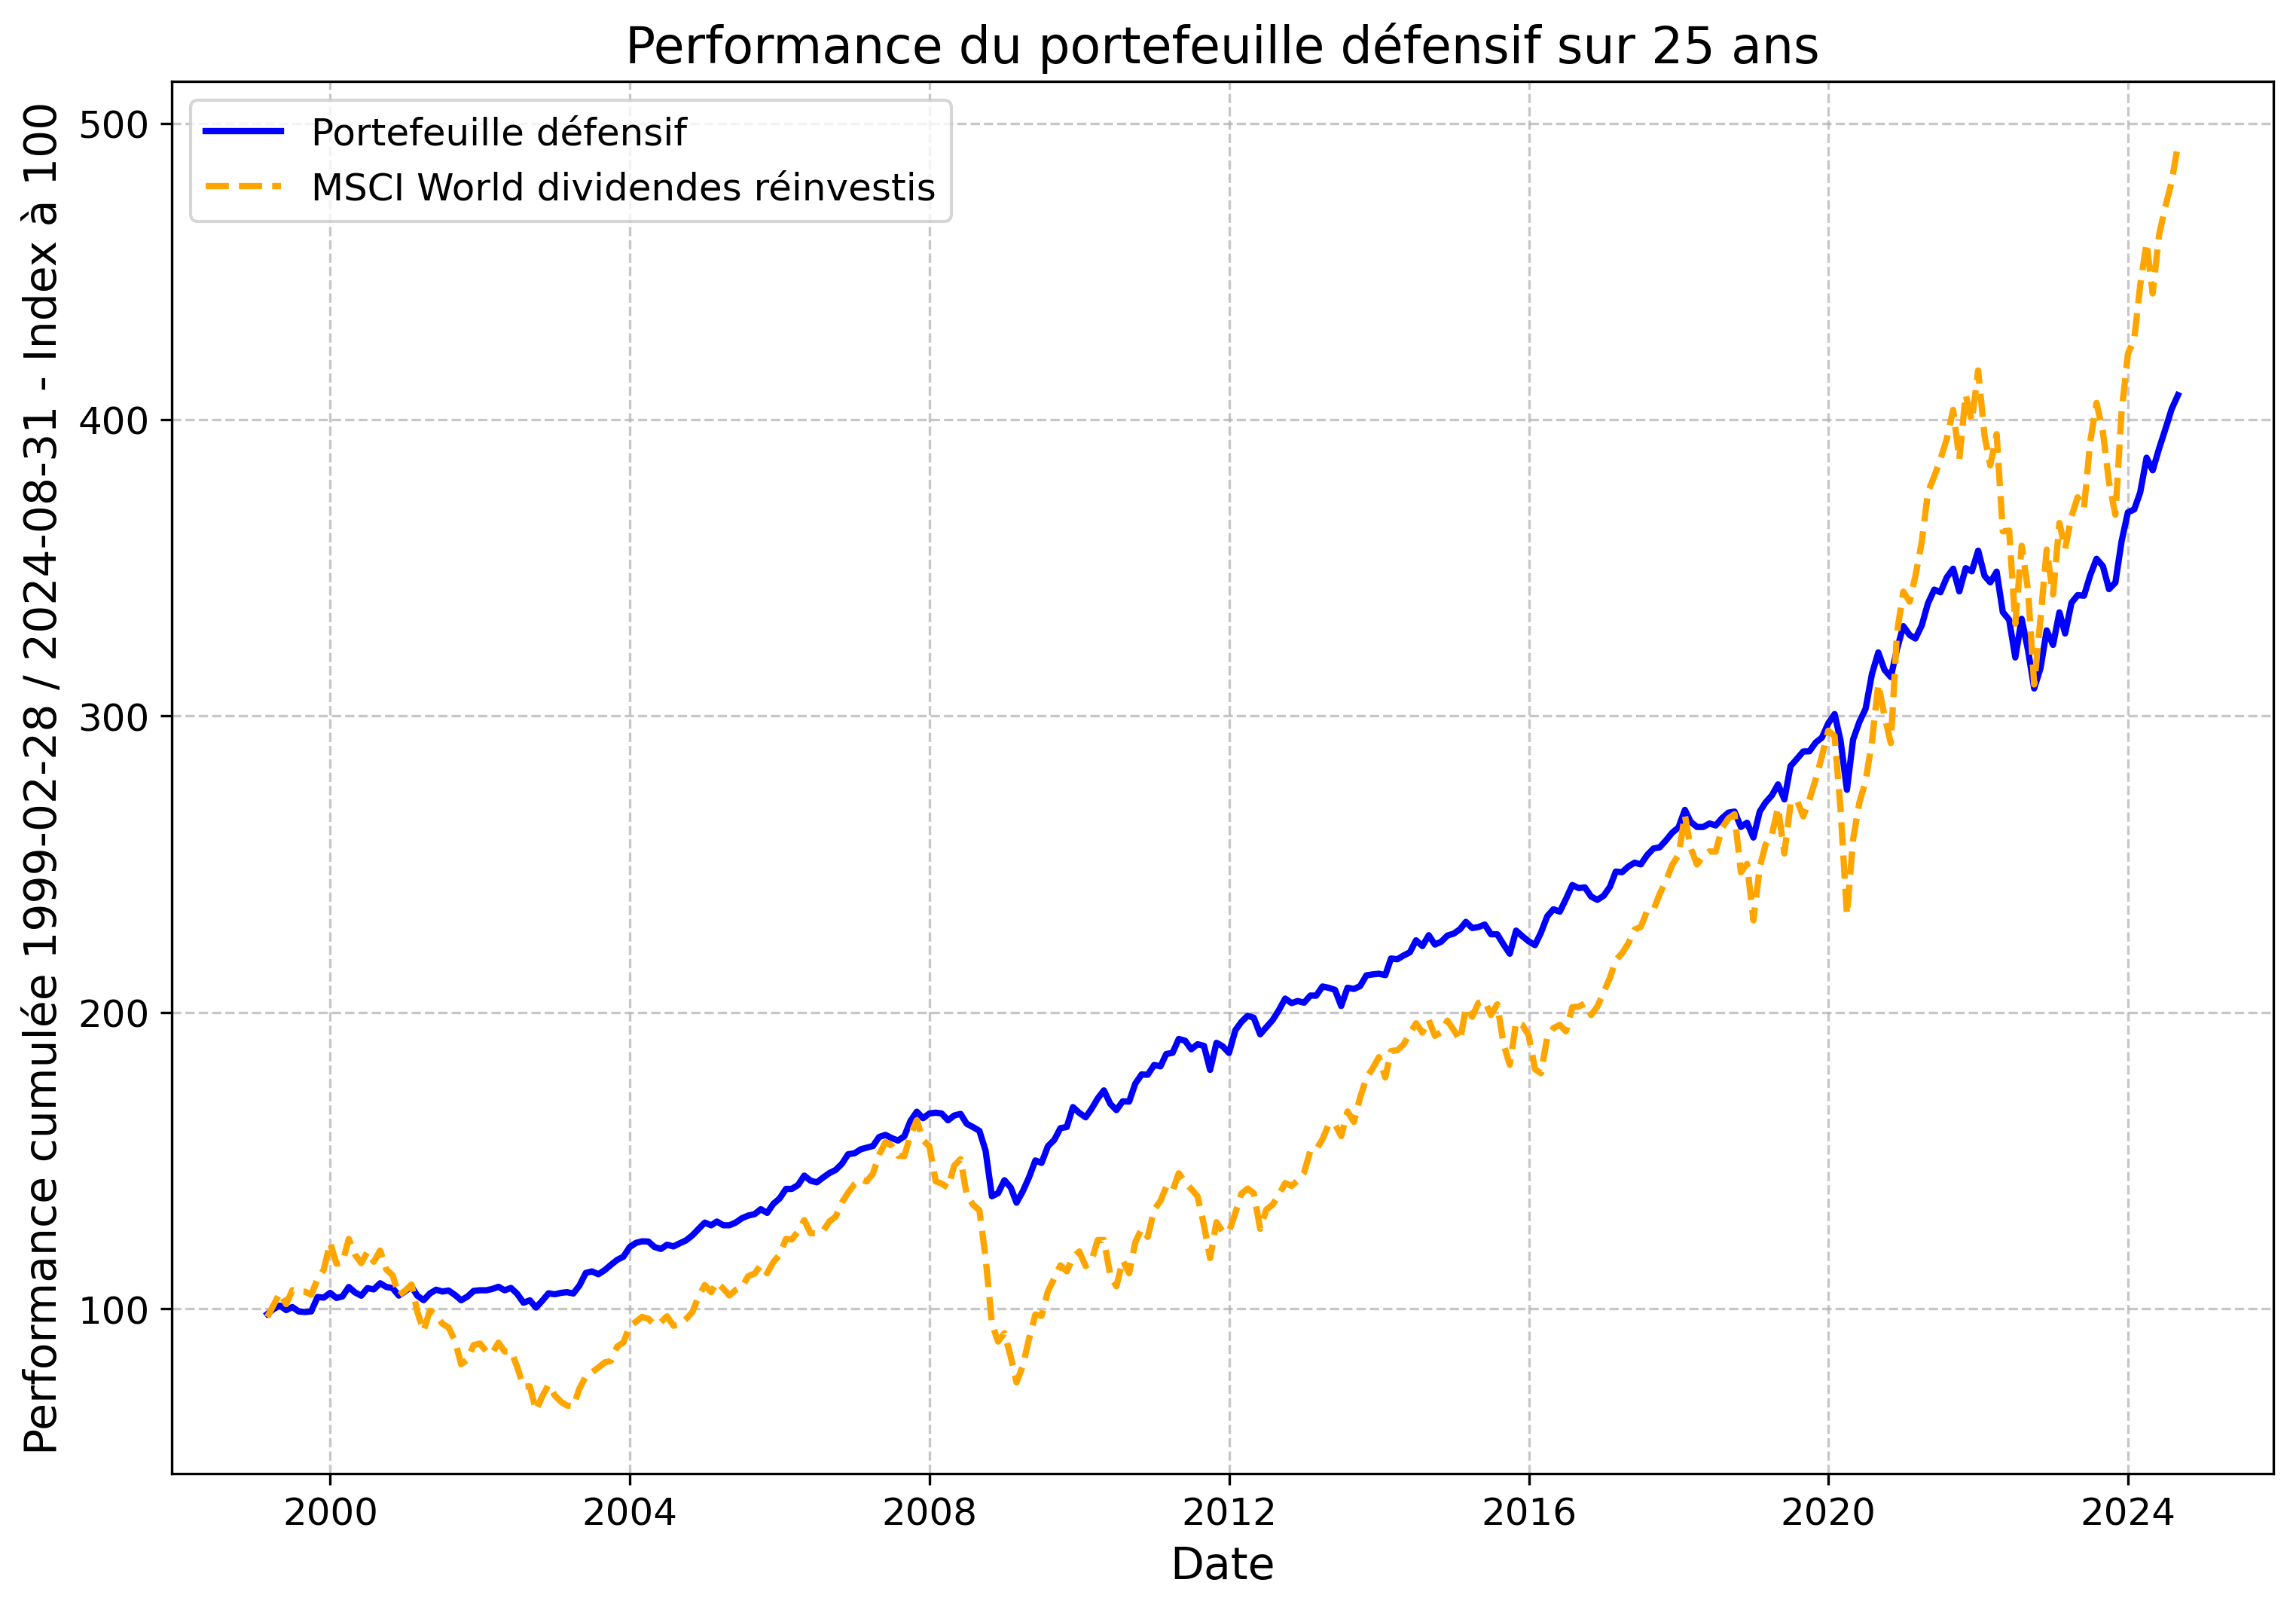

In [31]:
# Step 1: Extract the 'Adj Close' (or appropriate) column and resample to monthly data
sp_monthly = sp_data['Adj Close'].resample('M').last()
gold_monthly = gold_spot['Adjusted Close'].resample('M').last()
tbills_data_monthly = tbills_data['ETF Index'].resample('M').last()
euro_corp_bonds_monthly = euro_corp_bonds.resample('M').last()  # Adjust column name if different

# Step 2: Compute monthly percentage returns and assign a name to each Series
sp_returns = sp_monthly.pct_change().dropna()
sp_returns.name = 'SP500'

gold_returns = gold_monthly.pct_change().dropna()
gold_returns.name = 'Gold'

tbills_data_returns = tbills_data_monthly.pct_change().dropna()
tbills_data_returns.name = 'US_Treasury_Bills'

eurobonds_returns = euro_corp_bonds_monthly.pct_change().dropna()
eurobonds_returns.name = 'Euro Corp bonds'

# Step 3: Combine the returns into a DataFrame
returns_df = pd.concat(
    [
        sp_returns,
        gold_returns,
        tbills_data_returns,
        eurobonds_returns,
    ],
    axis=1
)

# Step 4: Drop rows with NaN values to align the dates
returns_df.dropna(inplace=True)

# Optional: Verify that the DataFrame now has 6 columns
print(f"Columns in returns_df: {returns_df.columns.tolist()}")  # Should list all 6 asset names

# Step 5: Define your portfolio weights
weights = [0.32, 0.16, 0.24, 0.28]

# Ensure weights sum to 1 (optional if weights are already normalized)
weights = [w / sum(weights) for w in weights]

# Step 6: Compute the portfolio returns
portfolio_returns = returns_df.dot(weights)

# Step 7: Index cumulative returns to 100 instead of 1
cumulative_returns_indexed = 100 * (1 + portfolio_returns).cumprod()

# For the benchmark, assuming you have MSCI World data:
# Resample to monthly data
msci_world_monthly = msci_world_data['MSCI World Net Return'].resample('M').last()

# Compute monthly returns
msci_world_returns = msci_world_monthly.pct_change().dropna()
msci_world_returns.name = 'MSCI_World'

# Align dates with portfolio returns
benchmark_returns = msci_world_returns.reindex(portfolio_returns.index).dropna()

# Compute cumulative returns for the benchmark
msci_world_cumulative_returns_indexed = 100 * (1 + benchmark_returns).cumprod()

# Step 8: Save everything in a variable called aggressive_portfolio
cumulative_returns_indexed.index = pd.to_datetime(cumulative_returns_indexed.index)

aggressive_portfolio = pd.DataFrame({
    'Portfolio_Returns': portfolio_returns,
    'Cumulative_Returns': cumulative_returns_indexed
})

# Step 9: Plot the performance, indexed at 100
plt.figure(figsize=(12, 8), dpi=300)
plt.plot(cumulative_returns_indexed, label='Portefeuille défensif', color='blue', linewidth=2)
plt.plot(msci_world_cumulative_returns_indexed, label='MSCI World dividendes réinvestis', color='orange', linestyle='--', linewidth=2)
plt.title('Performance du portefeuille défensif sur 25 ans', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Performance cumulée 1999-02-28 / 2024-08-31 - Index à 100', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [32]:
global_stats1 = ffn.calc_stats(cumulative_returns_indexed)
global_stats1.set_riskfree_rate(0.0164)
global_stats1.display()

Stats for None from 1999-02-28 00:00:00 - 2024-08-31 00:00:00
Annual risk-free rate considered: 1.64%
Summary:
Total Return    Sharpe    CAGR    Max Drawdown
--------------  --------  ------  --------------
315.35%         -         5.74%   -18.43%

Annualized Returns:
mtd    3m     6m     ytd     1y      3y     5y     10y    incep.
-----  -----  -----  ------  ------  -----  -----  -----  --------
1.18%  4.63%  8.74%  10.72%  16.45%  5.29%  7.22%  6.09%  5.74%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  -        0.65       0.57
mean    -        5.80%      5.82%
vol     -        6.40%      7.31%
skew    -        -0.69      -0.95
kurt    -        3.42       0.87
best    -        6.16%      15.82%
worst   -        -10.04%    -13.56%

Drawdowns:
max      avg       # days
-------  ------  --------
-18.43%  -2.49%    138.38

Misc:
---------------  ------
avg. up month    1.56%
avg. down month  -1.29%
up year %        80.00%
12m up %         82.

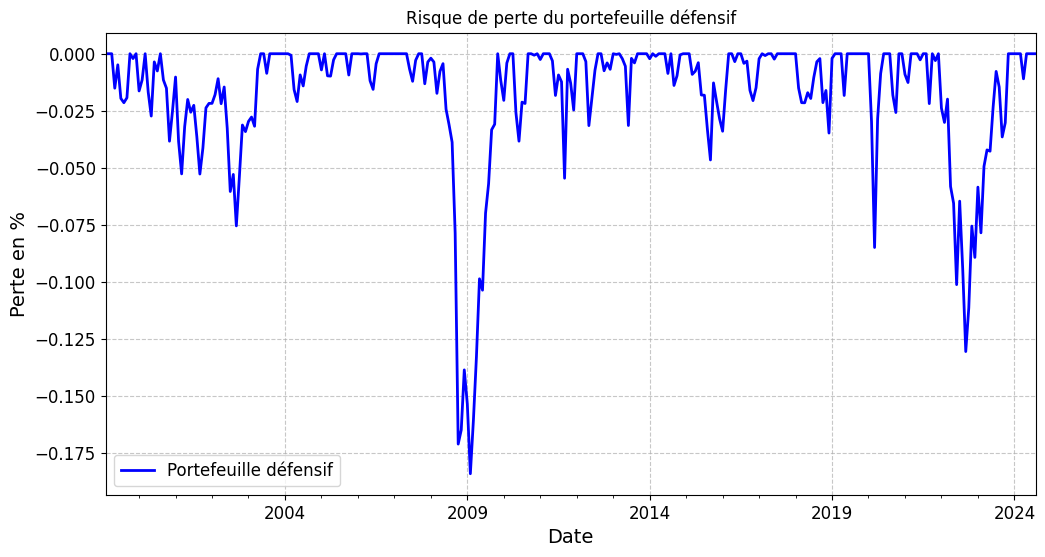

In [33]:
# Plot the drawdown series for the aggressive portfolio
drawdown1 = global_stats1.prices.to_drawdown_series().plot(
    figsize=(12, 6),
    grid=True, 
    title='Risque de perte du portefeuille défensif', 
    color='blue', 
    linewidth=2,
)

# Add labels and legend
plt.xlabel('Date', fontsize=14)
plt.ylabel('Perte en %', fontsize=14)
plt.legend(['Portefeuille défensif'], fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

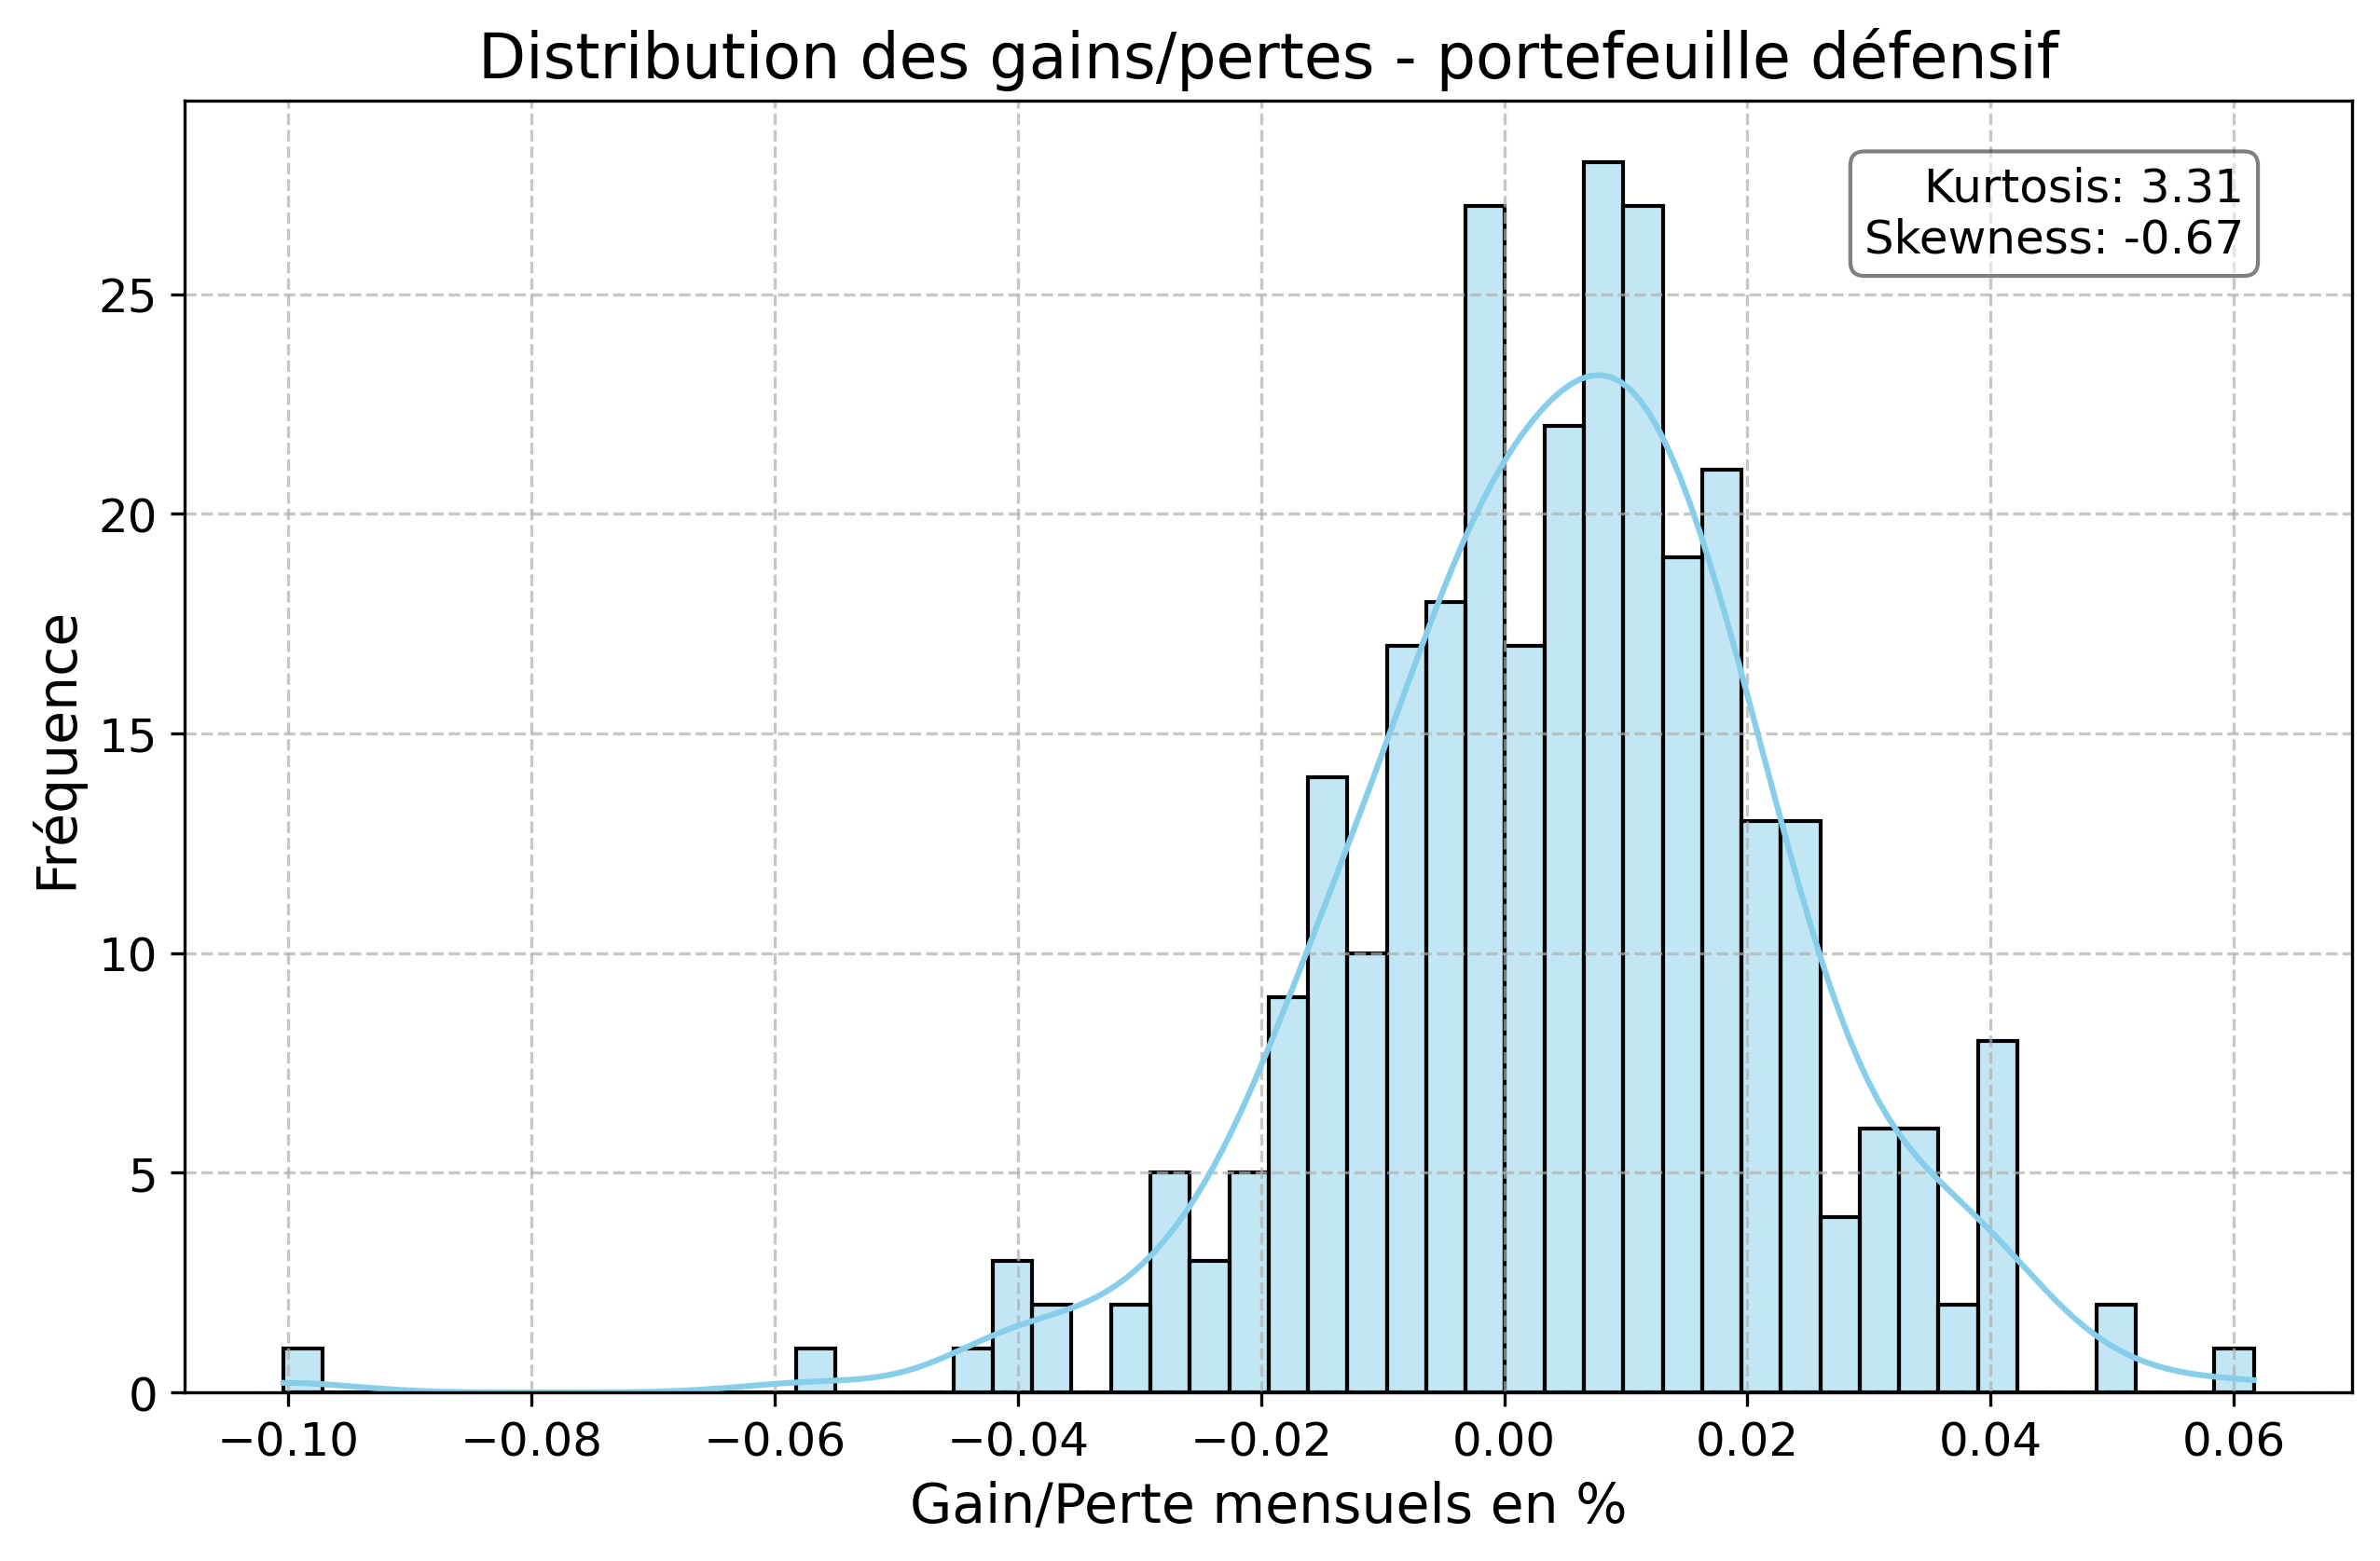

In [34]:
# Plot the histogram
plt.figure(figsize=(10, 6),  dpi=300)
sns.histplot(portfolio_returns, bins=50, kde=True, color='skyblue', edgecolor='black')

# Calculate kurtosis and skewness
kurt = kurtosis(portfolio_returns)
skewness = skew(portfolio_returns)

# Add text box with kurtosis and skewness
textstr = f'Kurtosis: {kurt:.2f}\nSkewness: {skewness:.2f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.gca().text(0.95, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
               verticalalignment='top', horizontalalignment='right', bbox=props)

# Add labels and title
plt.title('Distribution des gains/pertes - portefeuille défensif', fontsize=16)
plt.xlabel('Gain/Perte mensuels en %', fontsize=14)
plt.ylabel('Fréquence', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

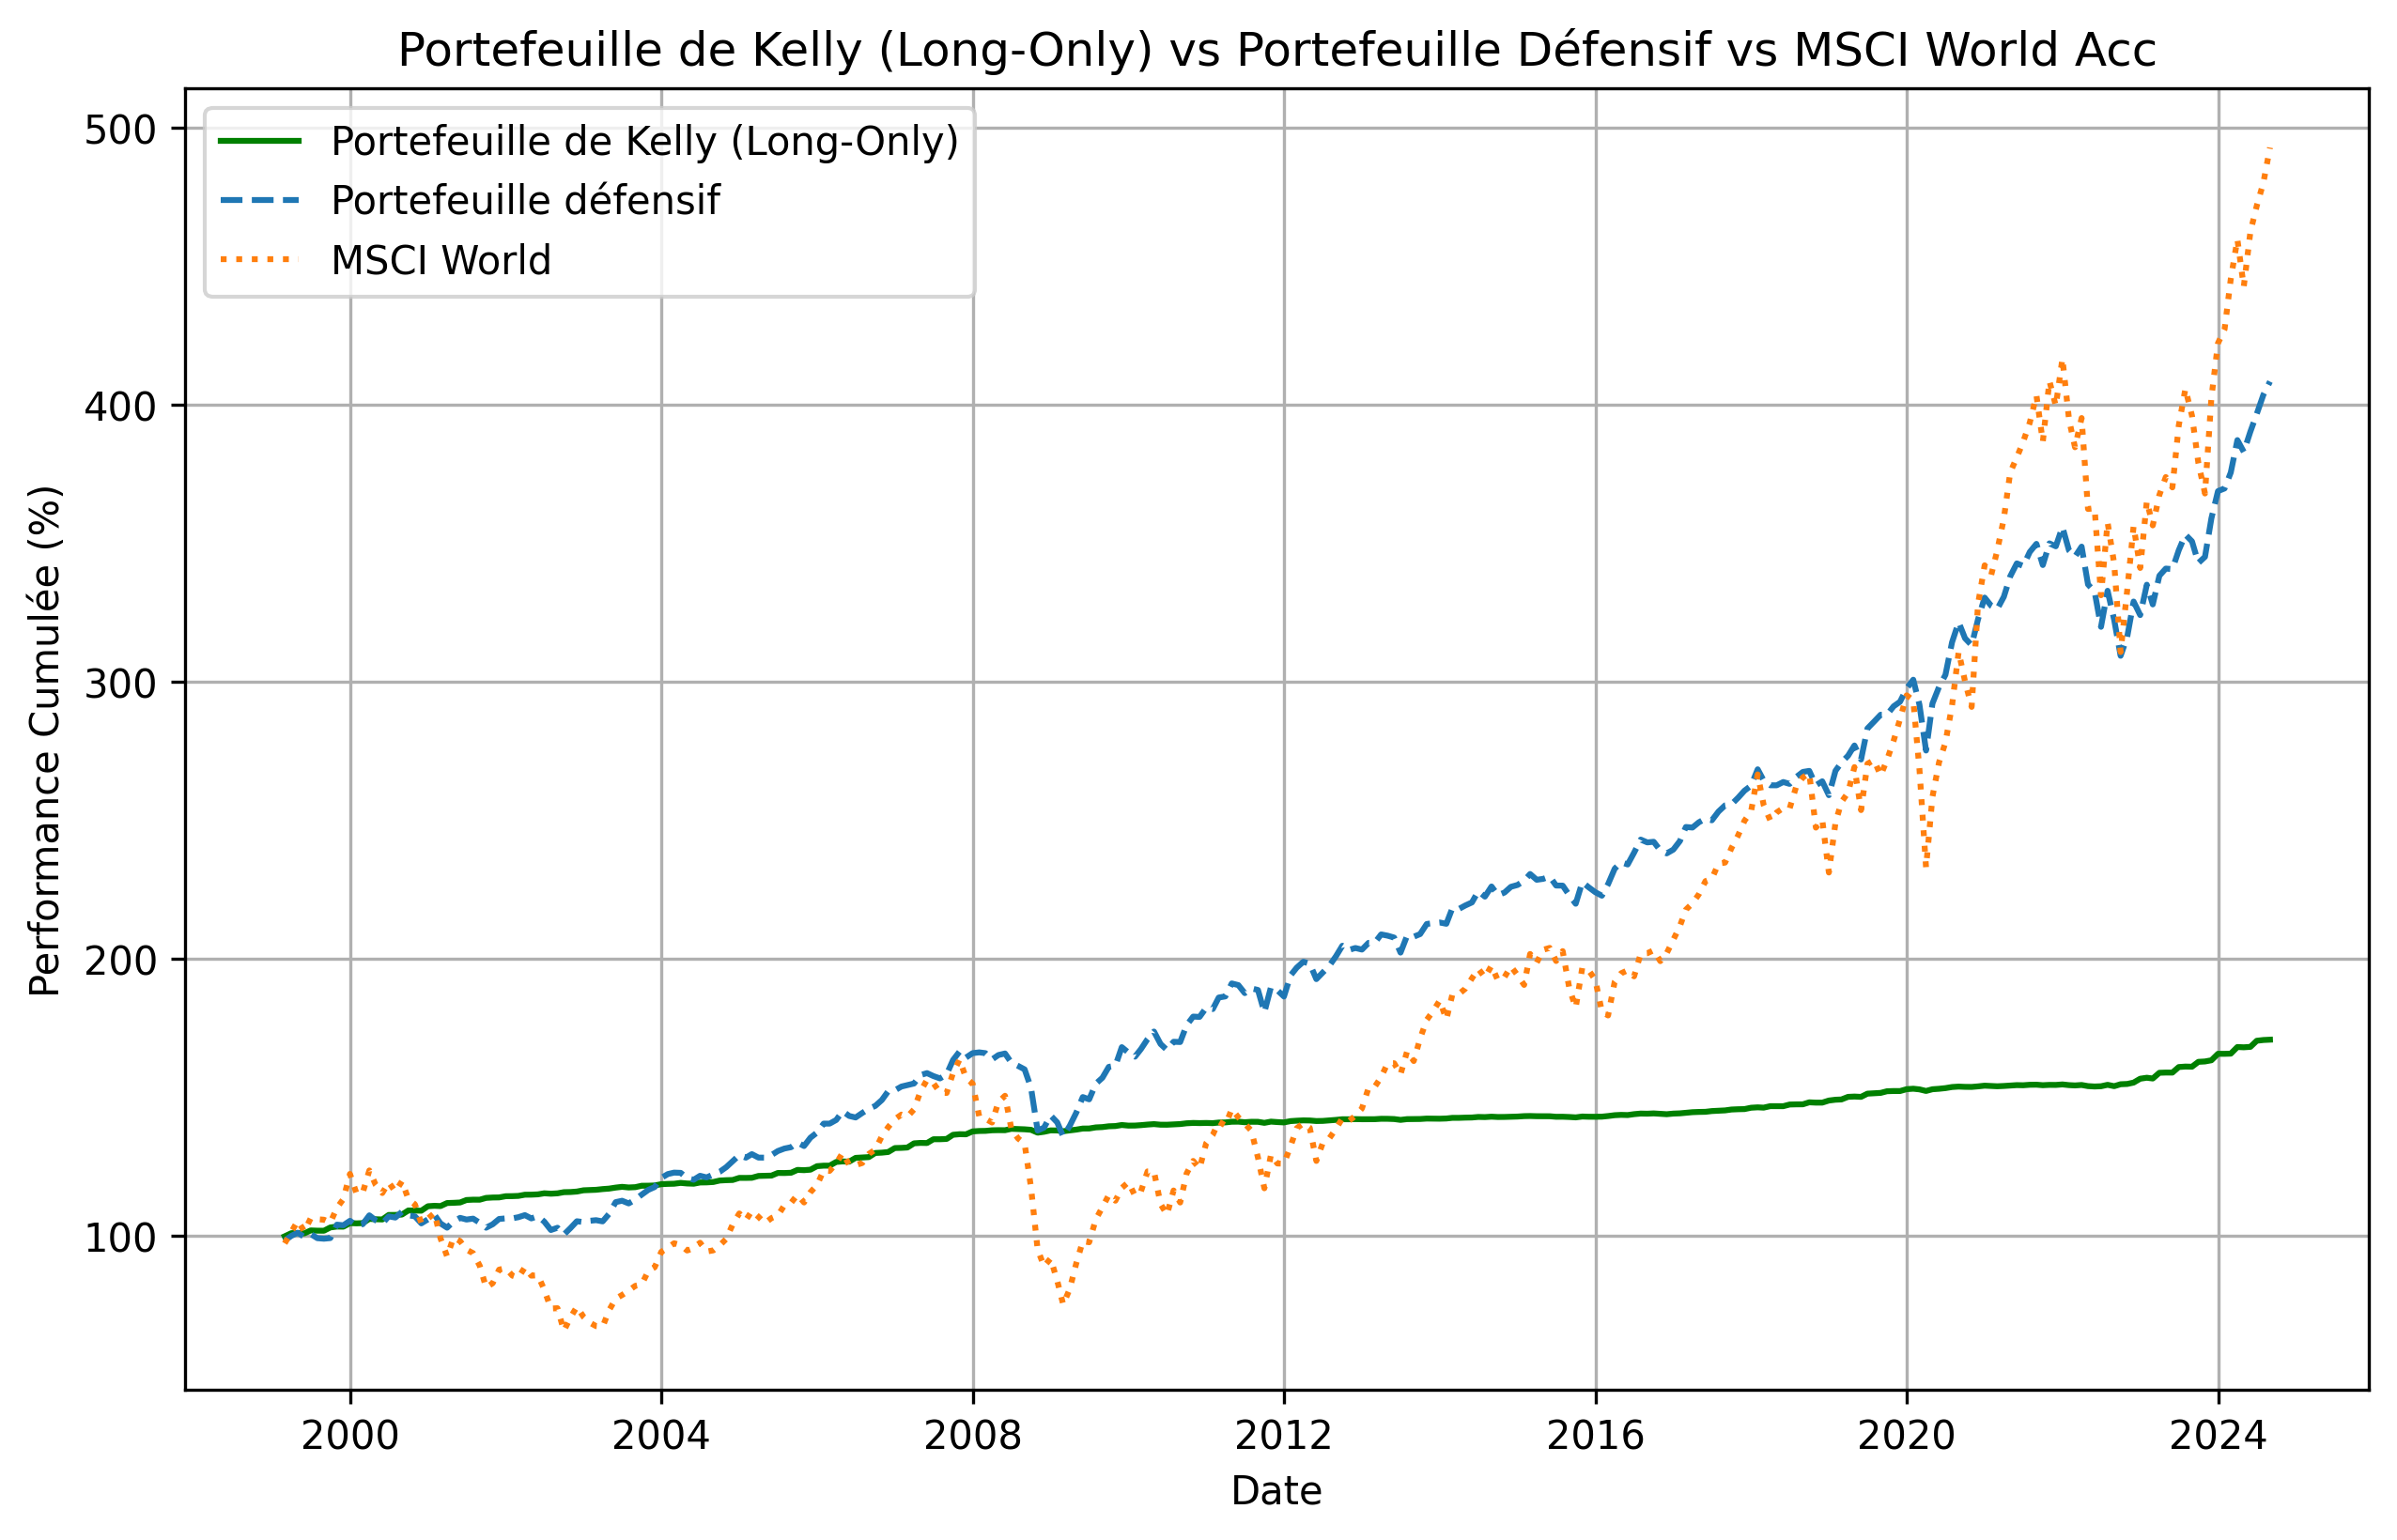

,Asset,Kelly Weights (Long-Only)
0,SP500,0.012821
1,Gold,0.012248
2,US_Treasury_Bills,0.929543
3,Price,0.045388


In [35]:
from scipy.optimize import minimize

expected_returns = returns_df.mean()  # Use the mean returns of individual assets
cov_matrix = returns_df.cov()  # Covariance matrix of the asset returns

# Step 1: Define the objective function (negative Kelly's criterion to minimize)
def kelly_criterion(weights, expected_returns, cov_matrix):
    # Negative of Kelly formula (since we are minimizing)
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    return -portfolio_return / portfolio_variance

# Step 2: Define constraints and bounds (no shorting or leverage)
num_assets = len(expected_returns)
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})  # Weights sum to 1
bounds = tuple((0, 1) for _ in range(num_assets))  # No shorting, weights between 0 and 1

# Step 3: Initial guess for weights (equal weight allocation)
initial_weights = num_assets * [1. / num_assets]

# Step 4: Optimize using scipy's minimize function
result = minimize(kelly_criterion, initial_weights, args=(expected_returns, cov_matrix),
                  method='SLSQP', bounds=bounds, constraints=constraints)

# Step 5: Get the optimized Kelly weights
kelly_weights_long_only = result.x

# Step 6: Compute the Kelly portfolio returns using the optimized weights
kelly_portfolio_returns_long_only = returns_df.dot(kelly_weights_long_only)

# Step 7: Compute cumulative returns for the long-only Kelly portfolio
kelly_cumulative_returns_long_only = (1 + kelly_portfolio_returns_long_only).cumprod() * 100

# Step 8: Plot the performance of the long-only Kelly portfolio and compare it with the aggressive portfolio and MSCI World
plt.figure(figsize=(10, 6), dpi=300)

# Plot long-only Kelly portfolio cumulative returns
plt.plot(kelly_cumulative_returns_long_only, label='Portefeuille de Kelly (Long-Only)', color='green')

# Plot aggressive portfolio cumulative returns
plt.plot(cumulative_returns_indexed, label='Portefeuille défensif', linestyle='--')

# Plot MSCI World cumulative returns
plt.plot(msci_world_cumulative_returns_indexed, label='MSCI World', linestyle=':')

plt.title('Portefeuille de Kelly (Long-Only) vs Portefeuille Défensif vs MSCI World Acc')
plt.xlabel('Date')
plt.ylabel('Performance Cumulée (%)')
plt.legend()
plt.grid(True)
plt.show()

# Display the optimized Kelly weights for each asset
kelly_weights_long_only_df = pd.DataFrame({
    'Asset': returns_df.columns,
    'Kelly Weights (Long-Only)': kelly_weights_long_only
})
kelly_weights_long_only_df

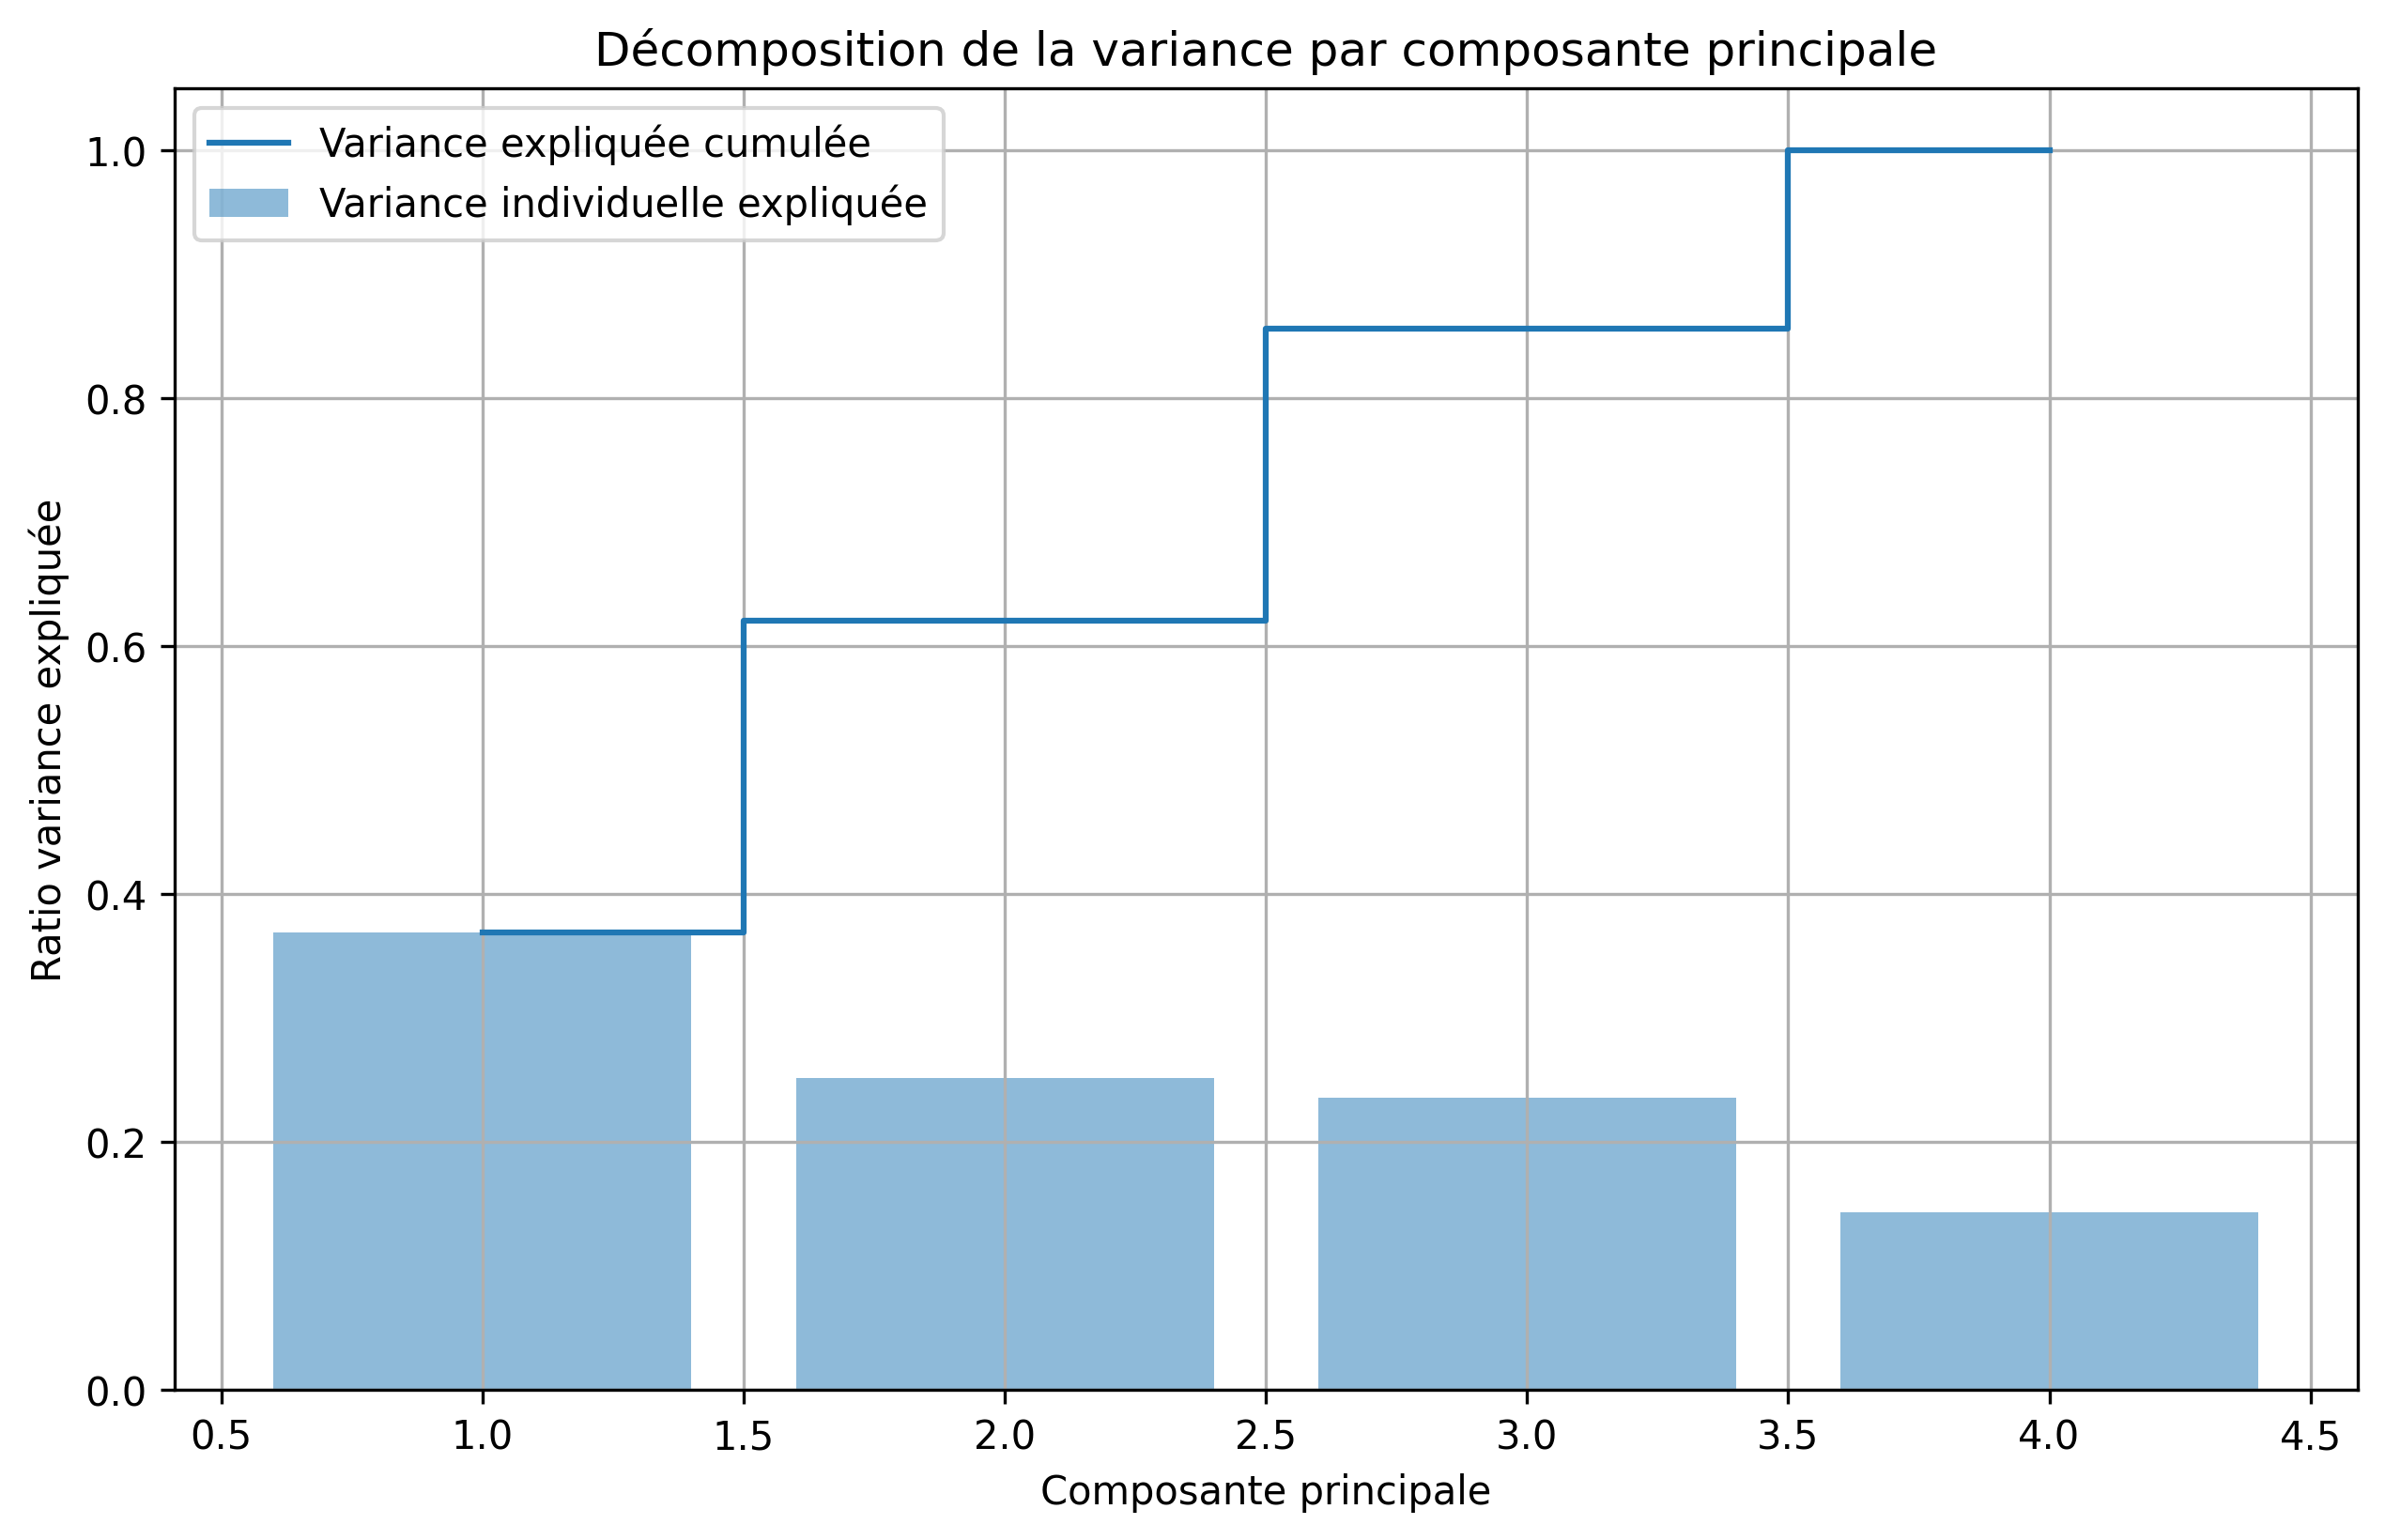

,SP500,Gold,US_Treasury_Bills,Price
PC1,0.578838,0.440030,-0.040986,0.685303
PC2,-0.176209,0.251343,0.950691,0.044306
PC3,-0.545956,0.778497,-0.304357,-0.056932
PC4,-0.579508,-0.370328,-0.043276,0.724676


In [36]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Standardize the data (mean=0, variance=1)
scaler = StandardScaler()
returns_scaled = scaler.fit_transform(returns_df)

# Step 2: Perform PCA
pca = PCA()
pca.fit(returns_scaled)

# Step 3: Get the explained variance ratio for each principal component
explained_variance = pca.explained_variance_ratio_

# Step 4: Plot the explained variance
plt.figure(figsize=(10, 6), dpi=300)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Variance individuelle expliquée')
plt.step(range(1, len(explained_variance) + 1), explained_variance.cumsum(), where='mid', label='Variance expliquée cumulée')
plt.title('Décomposition de la variance par composante principale')
plt.xlabel('Composante principale')
plt.ylabel('Ratio variance expliquée')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Step 5: Display the PCA components (principal axes in feature space)
pca_components = pd.DataFrame(pca.components_, columns=returns_df.columns, index=[f'PC{i+1}' for i in range(len(returns_df.columns))])
pca_components

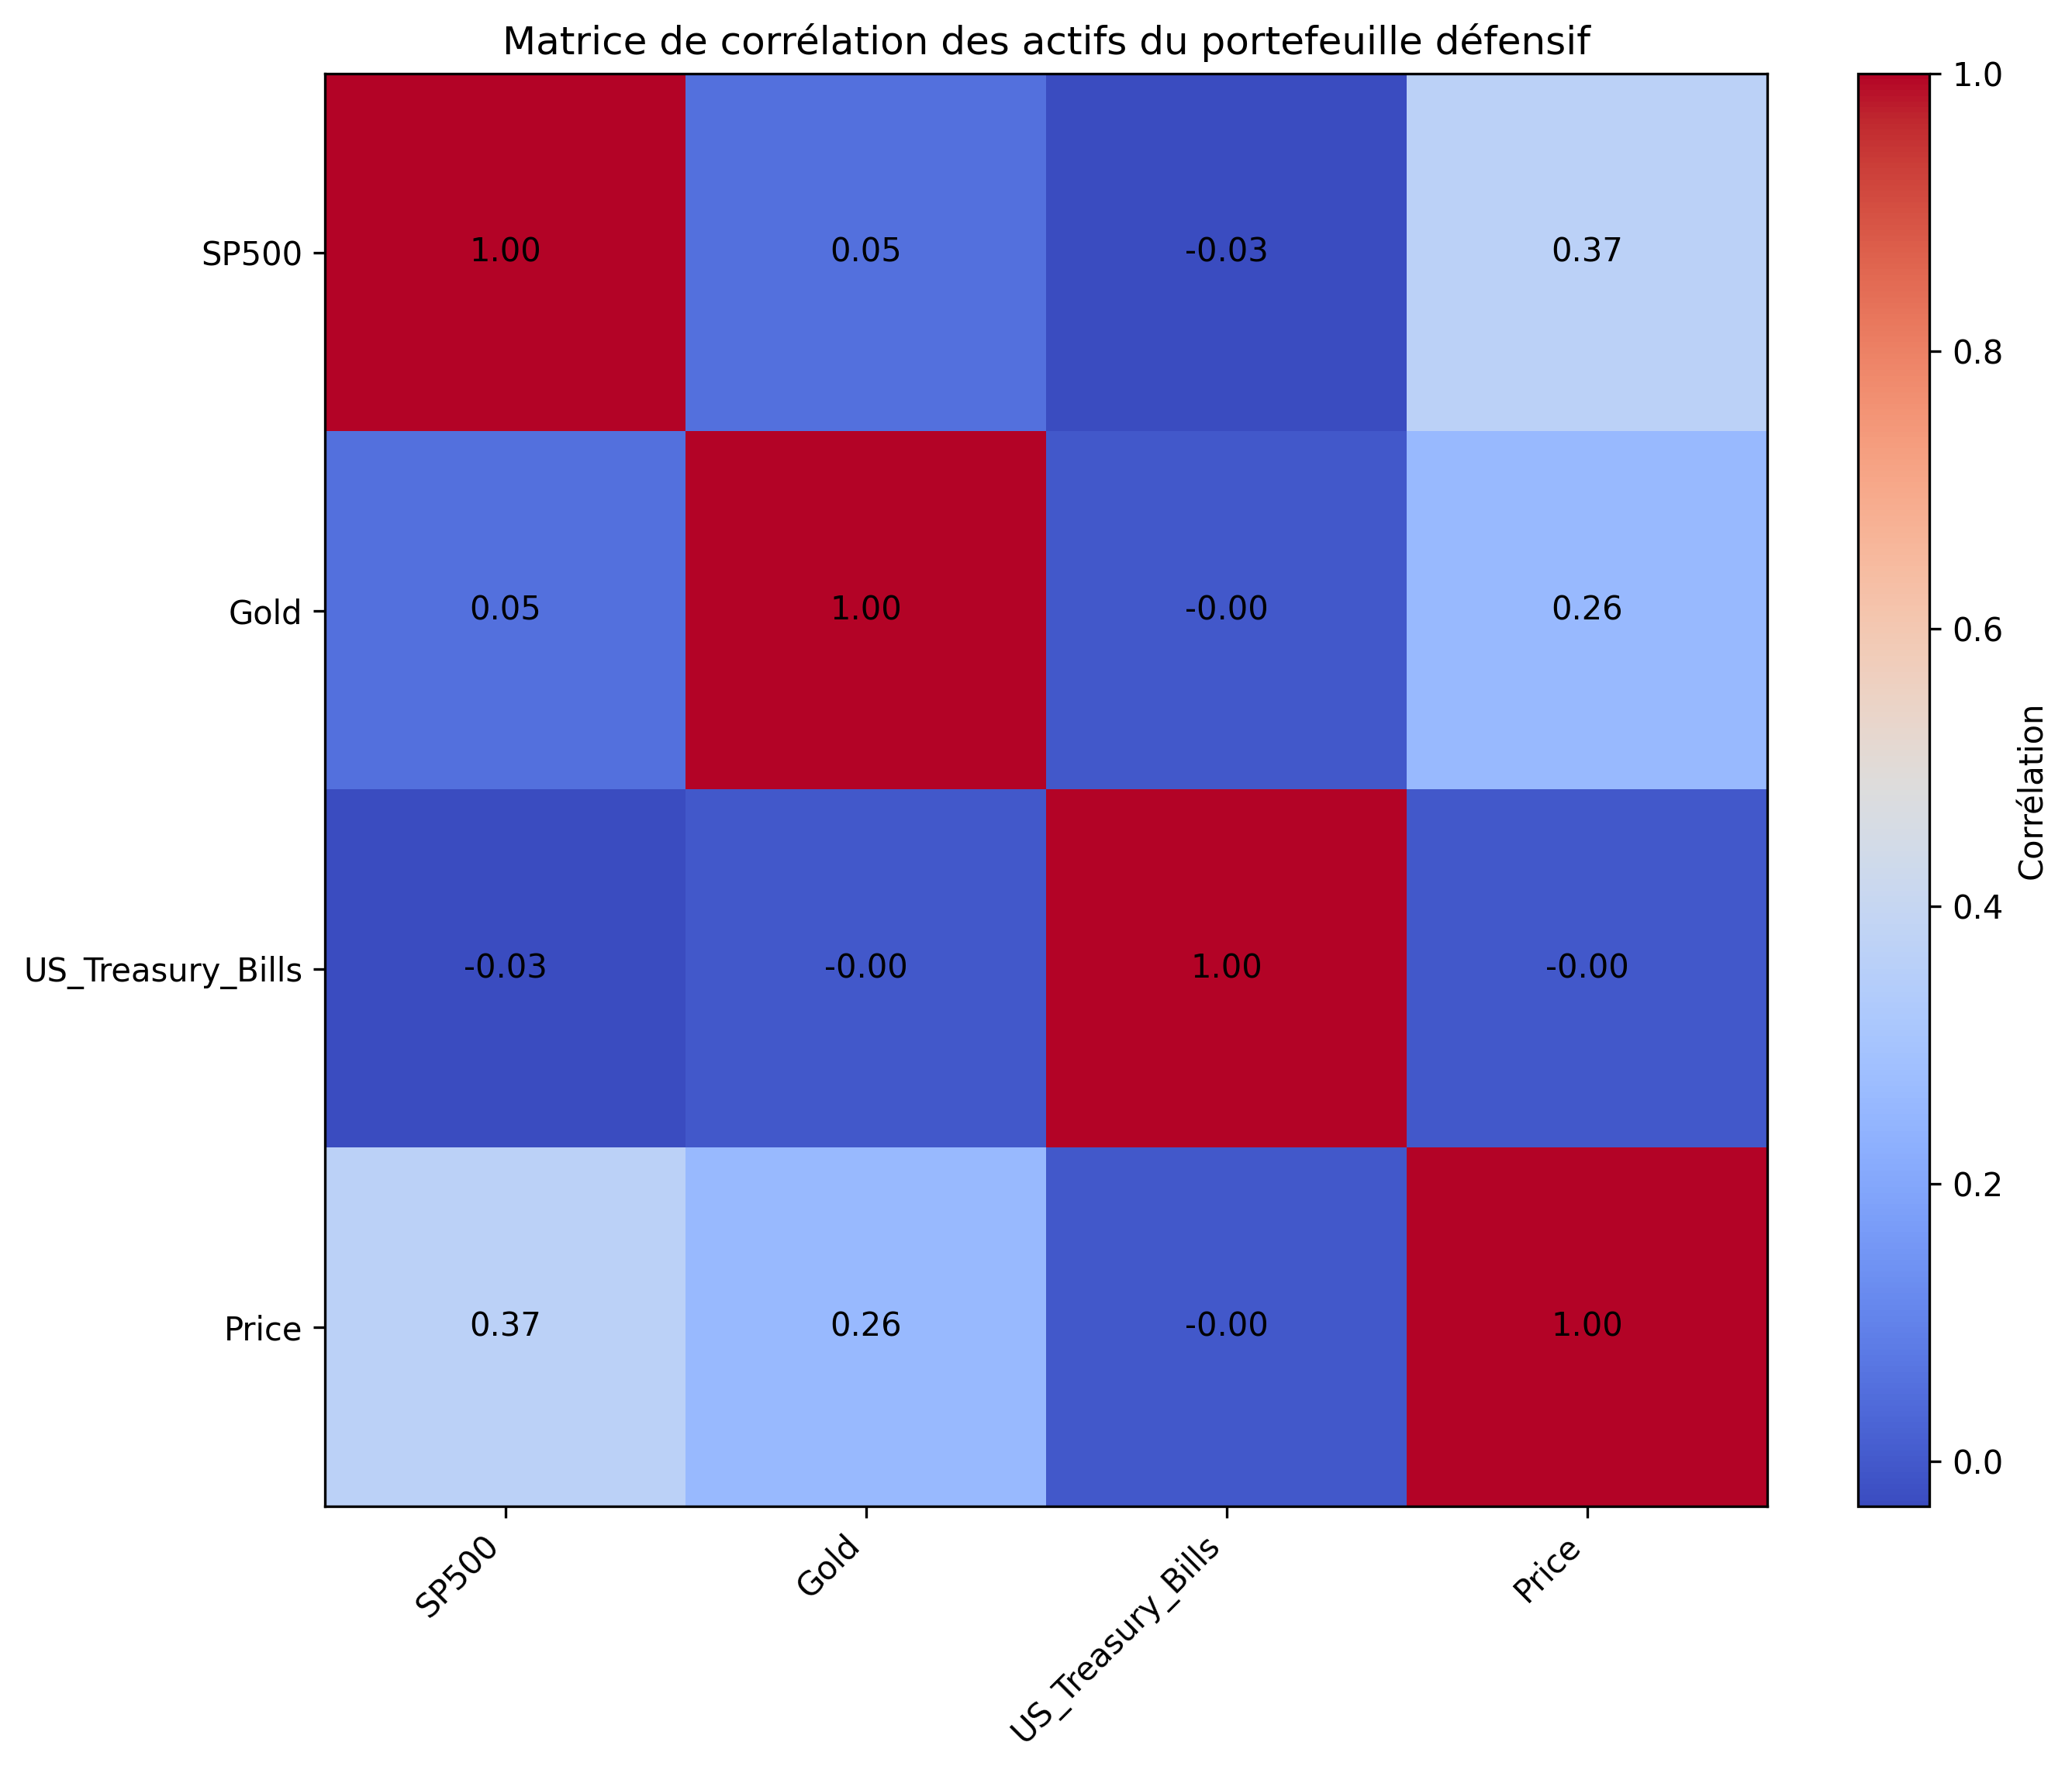

,SP500,Gold,US_Treasury_Bills,Price
SP500,1.000000,0.053762,-0.032353,0.366200
Gold,0.053762,1.000000,-0.000652,0.260647
US_Treasury_Bills,-0.032353,-0.000652,1.000000,-0.000765
Price,0.366200,0.260647,-0.000765,1.000000


In [37]:
# Step 1: Compute the correlation matrix of the portfolio assets
correlation_matrix = returns_df.corr()

# Step 2: Plot the correlation matrix as a heatmap with numbers
plt.figure(figsize=(10, 8), dpi=300)
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none', aspect='auto')
plt.colorbar(label='Corrélation')

# Add the correlation numbers on the heatmap
for (i, j), val in np.ndenumerate(correlation_matrix):
    plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

# Set x and y axis labels
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Matrice de corrélation des actifs du portefeuille défensif')
plt.grid(False)
plt.show()

# Step 3: Optionally, display the correlation matrix as a DataFrame
correlation_matrix

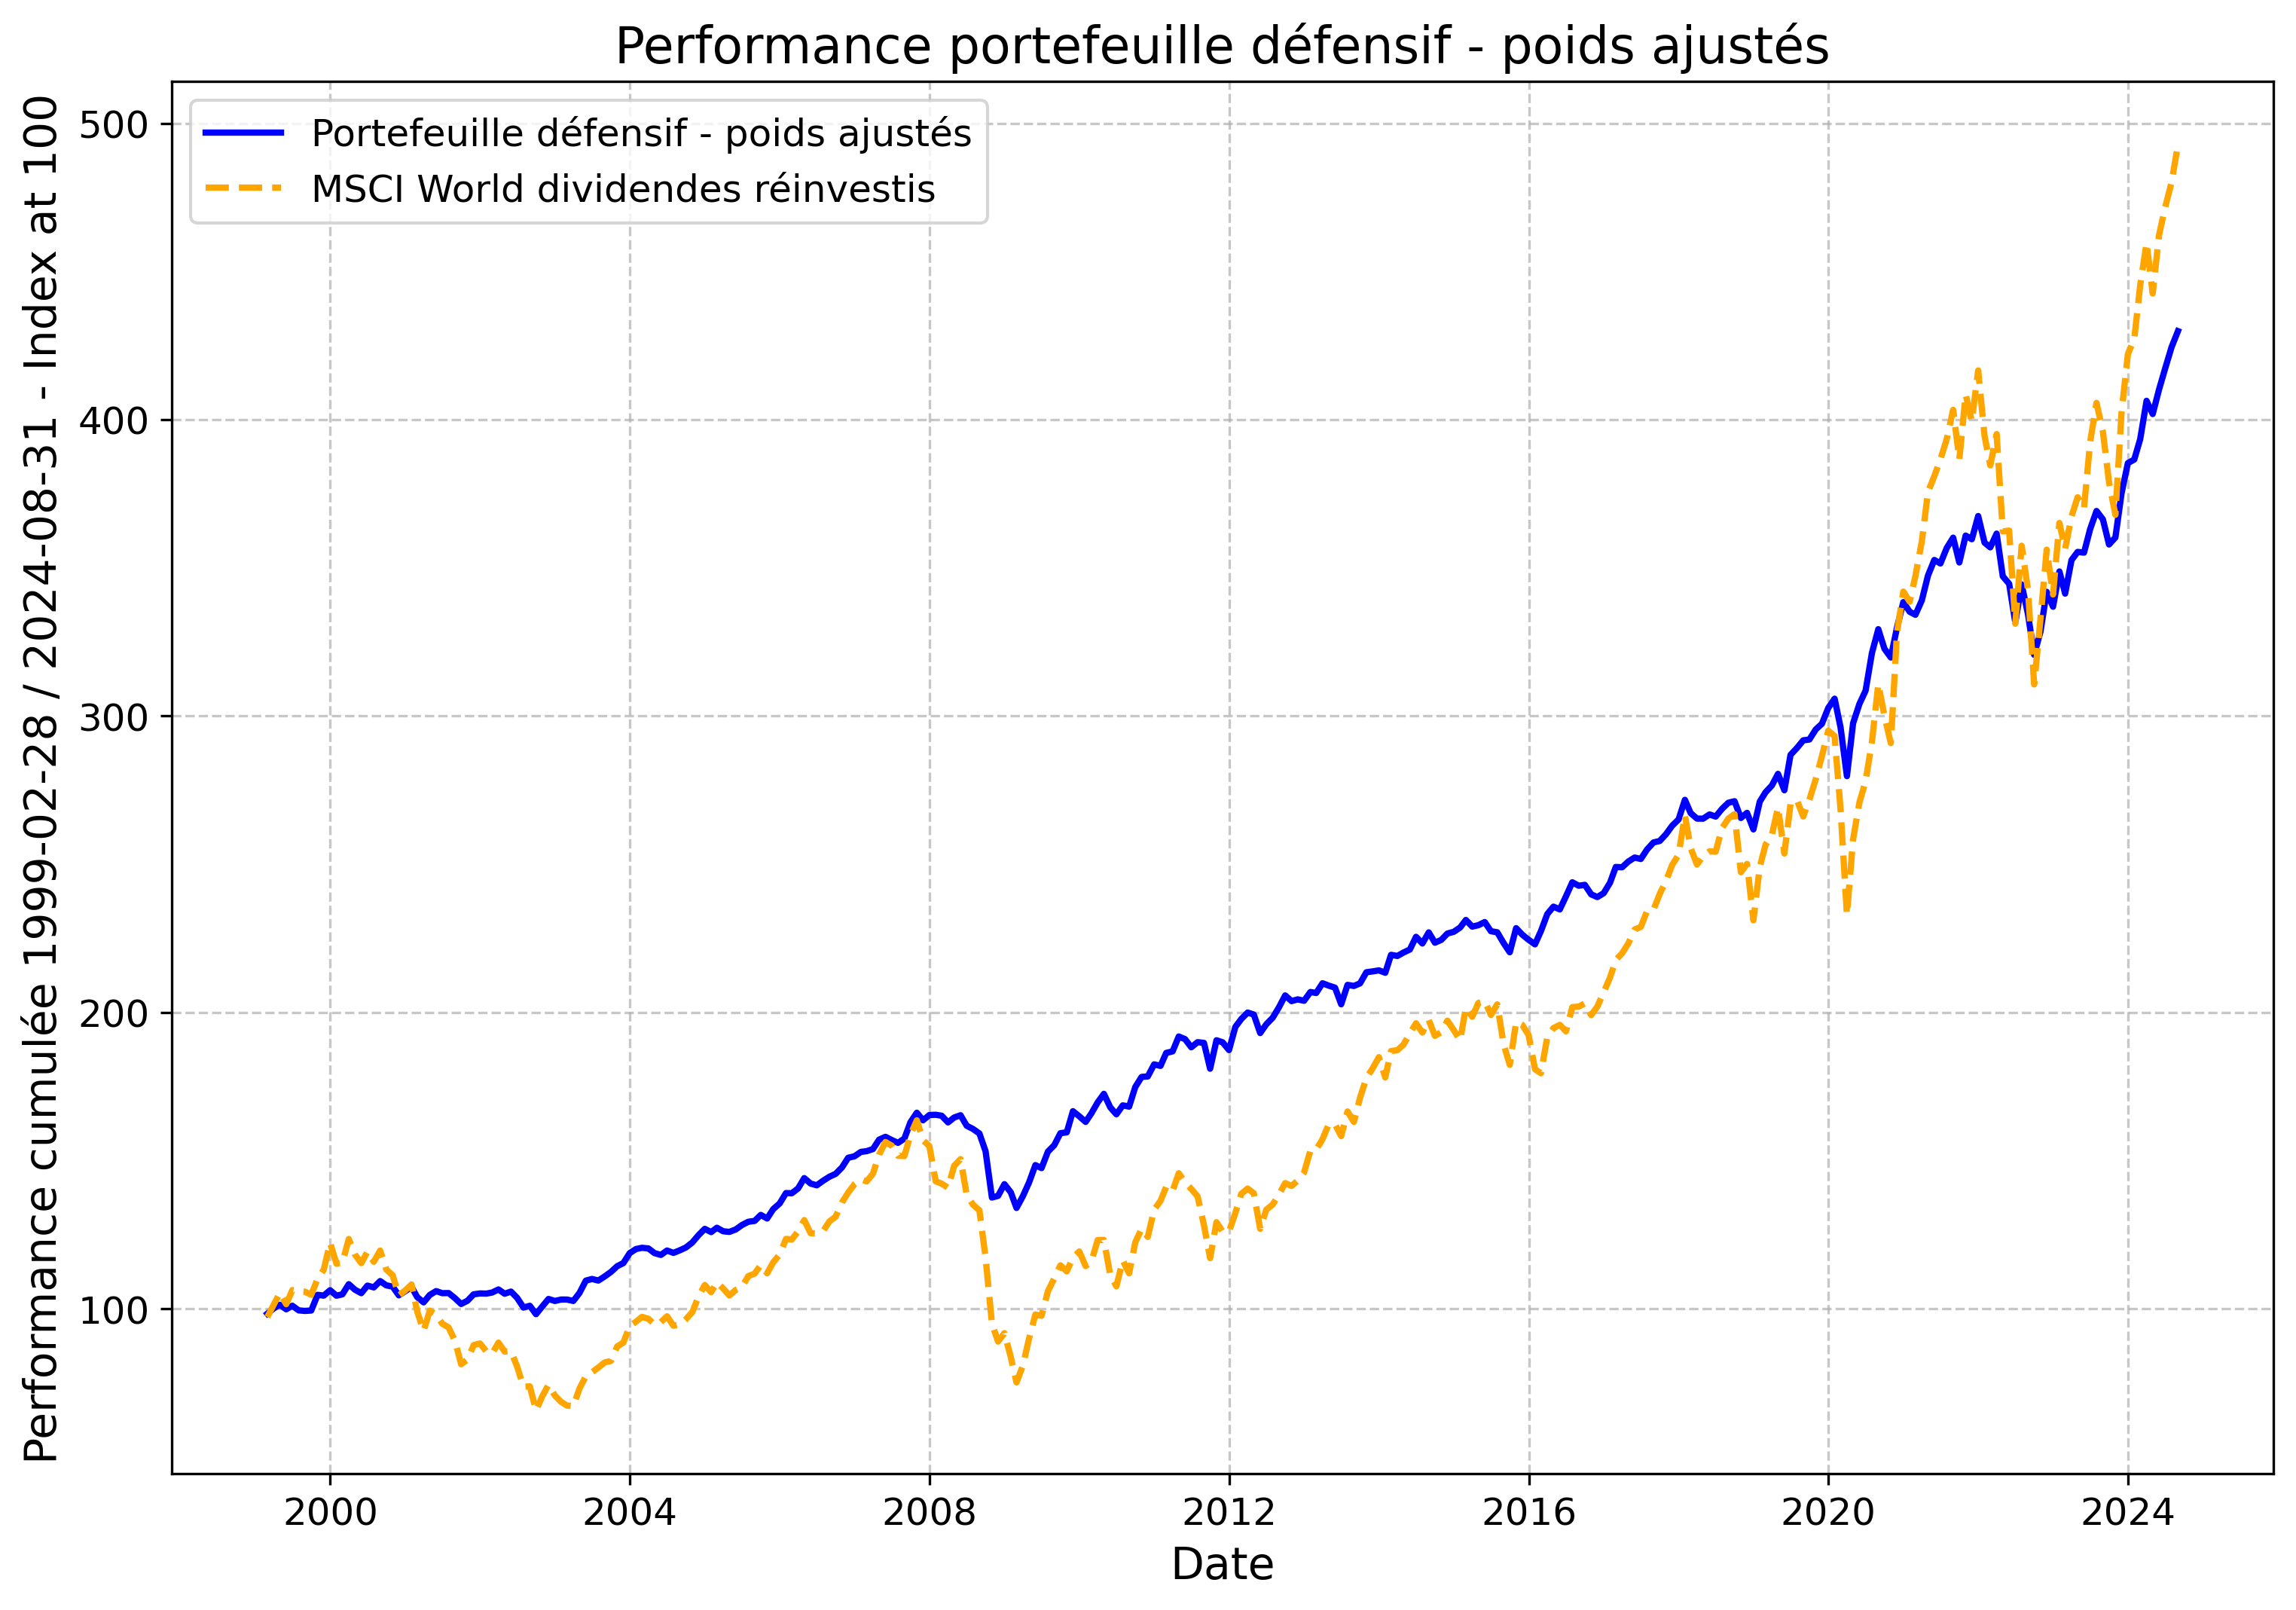

In [38]:
# Step 5: Define your portfolio weights
weights2 = [0.35, 0.175, 0.275, 0.2]

# Ensure weights sum to 1 (optional if weights are already normalized)
weights = [w / sum(weights2) for w in weights2]

# Step 6: Compute the portfolio returns
portfolio_returns2 = returns_df.dot(weights2)

# Step 7: Index cumulative returns to 100 instead of 1
cumulative_returns_indexed2 = 100 * (1 + portfolio_returns2).cumprod()

# Step 8: Save everything in a variable called aggressive_portfolio
cumulative_returns_indexed2.index = pd.to_datetime(cumulative_returns_indexed2.index)

aggressive_portfolio2 = pd.DataFrame({
    'Portfolio_Returns': portfolio_returns,
    'Cumulative_Returns': cumulative_returns_indexed2
})

# Step 9: Plot the performance, indexed at 100
plt.figure(figsize=(12, 8), dpi=300)
plt.plot(cumulative_returns_indexed2, label='Portefeuille défensif - poids ajustés', color='blue', linewidth=2)
plt.plot(msci_world_cumulative_returns_indexed, label='MSCI World dividendes réinvestis', color='orange', linestyle='--', linewidth=2)
plt.title('Performance portefeuille défensif - poids ajustés', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Performance cumulée 1999-02-28 / 2024-08-31 - Index at 100', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [39]:
global_stats2 = ffn.calc_stats(cumulative_returns_indexed2)
global_stats2.set_riskfree_rate(0.0164)
global_stats2.display()

Stats for None from 1999-02-28 00:00:00 - 2024-08-31 00:00:00
Annual risk-free rate considered: 1.64%
Summary:
Total Return    Sharpe    CAGR    Max Drawdown
--------------  --------  ------  --------------
336.80%         -         5.95%   -19.33%

Annualized Returns:
mtd    3m     6m     ytd     1y      3y     5y     10y    incep.
-----  -----  -----  ------  ------  -----  -----  -----  --------
1.27%  4.79%  9.26%  11.55%  17.32%  6.07%  8.05%  6.59%  5.95%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  -        0.66       0.57
mean    -        6.02%      6.02%
vol     -        6.68%      7.66%
skew    -        -0.61      -0.89
kurt    -        2.96       0.60
best    -        6.38%      16.11%
worst   -        -10.20%    -14.09%

Drawdowns:
max      avg       # days
-------  ------  --------
-19.33%  -2.70%    137.64

Misc:
---------------  ------
avg. up month    1.64%
avg. down month  -1.34%
up year %        72.00%
12m up %         81.

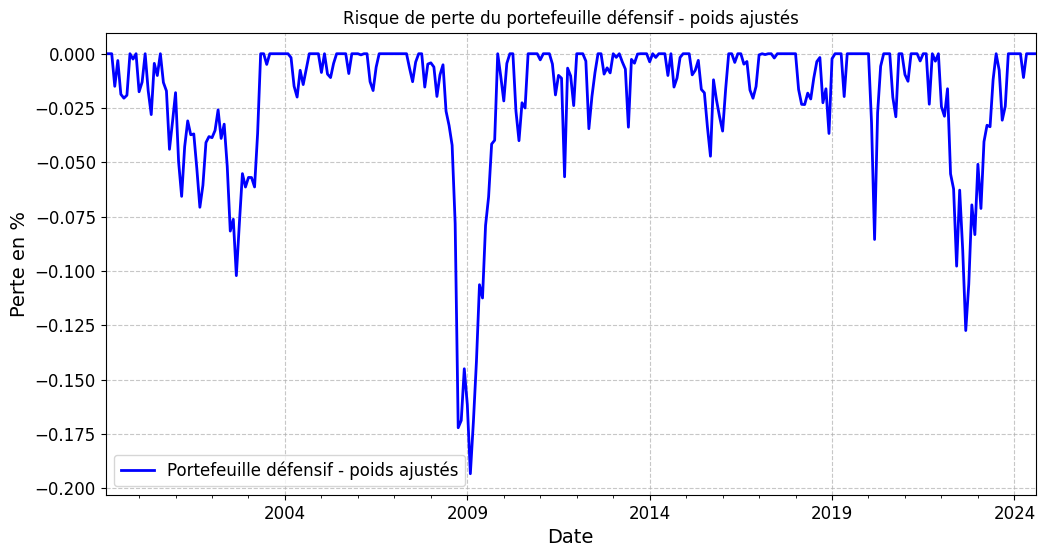

In [40]:
# Plot the drawdown series for the aggressive portfolio
drawdown2 = global_stats2.prices.to_drawdown_series().plot(
    figsize=(12, 6),
    grid=True, 
    title='Risque de perte du portefeuille défensif - poids ajustés', 
    color='blue', 
    linewidth=2,
)

# Add labels and legend
plt.xlabel('Date', fontsize=14)
plt.ylabel('Perte en %', fontsize=14)
plt.legend(['Portefeuille défensif - poids ajustés'], fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

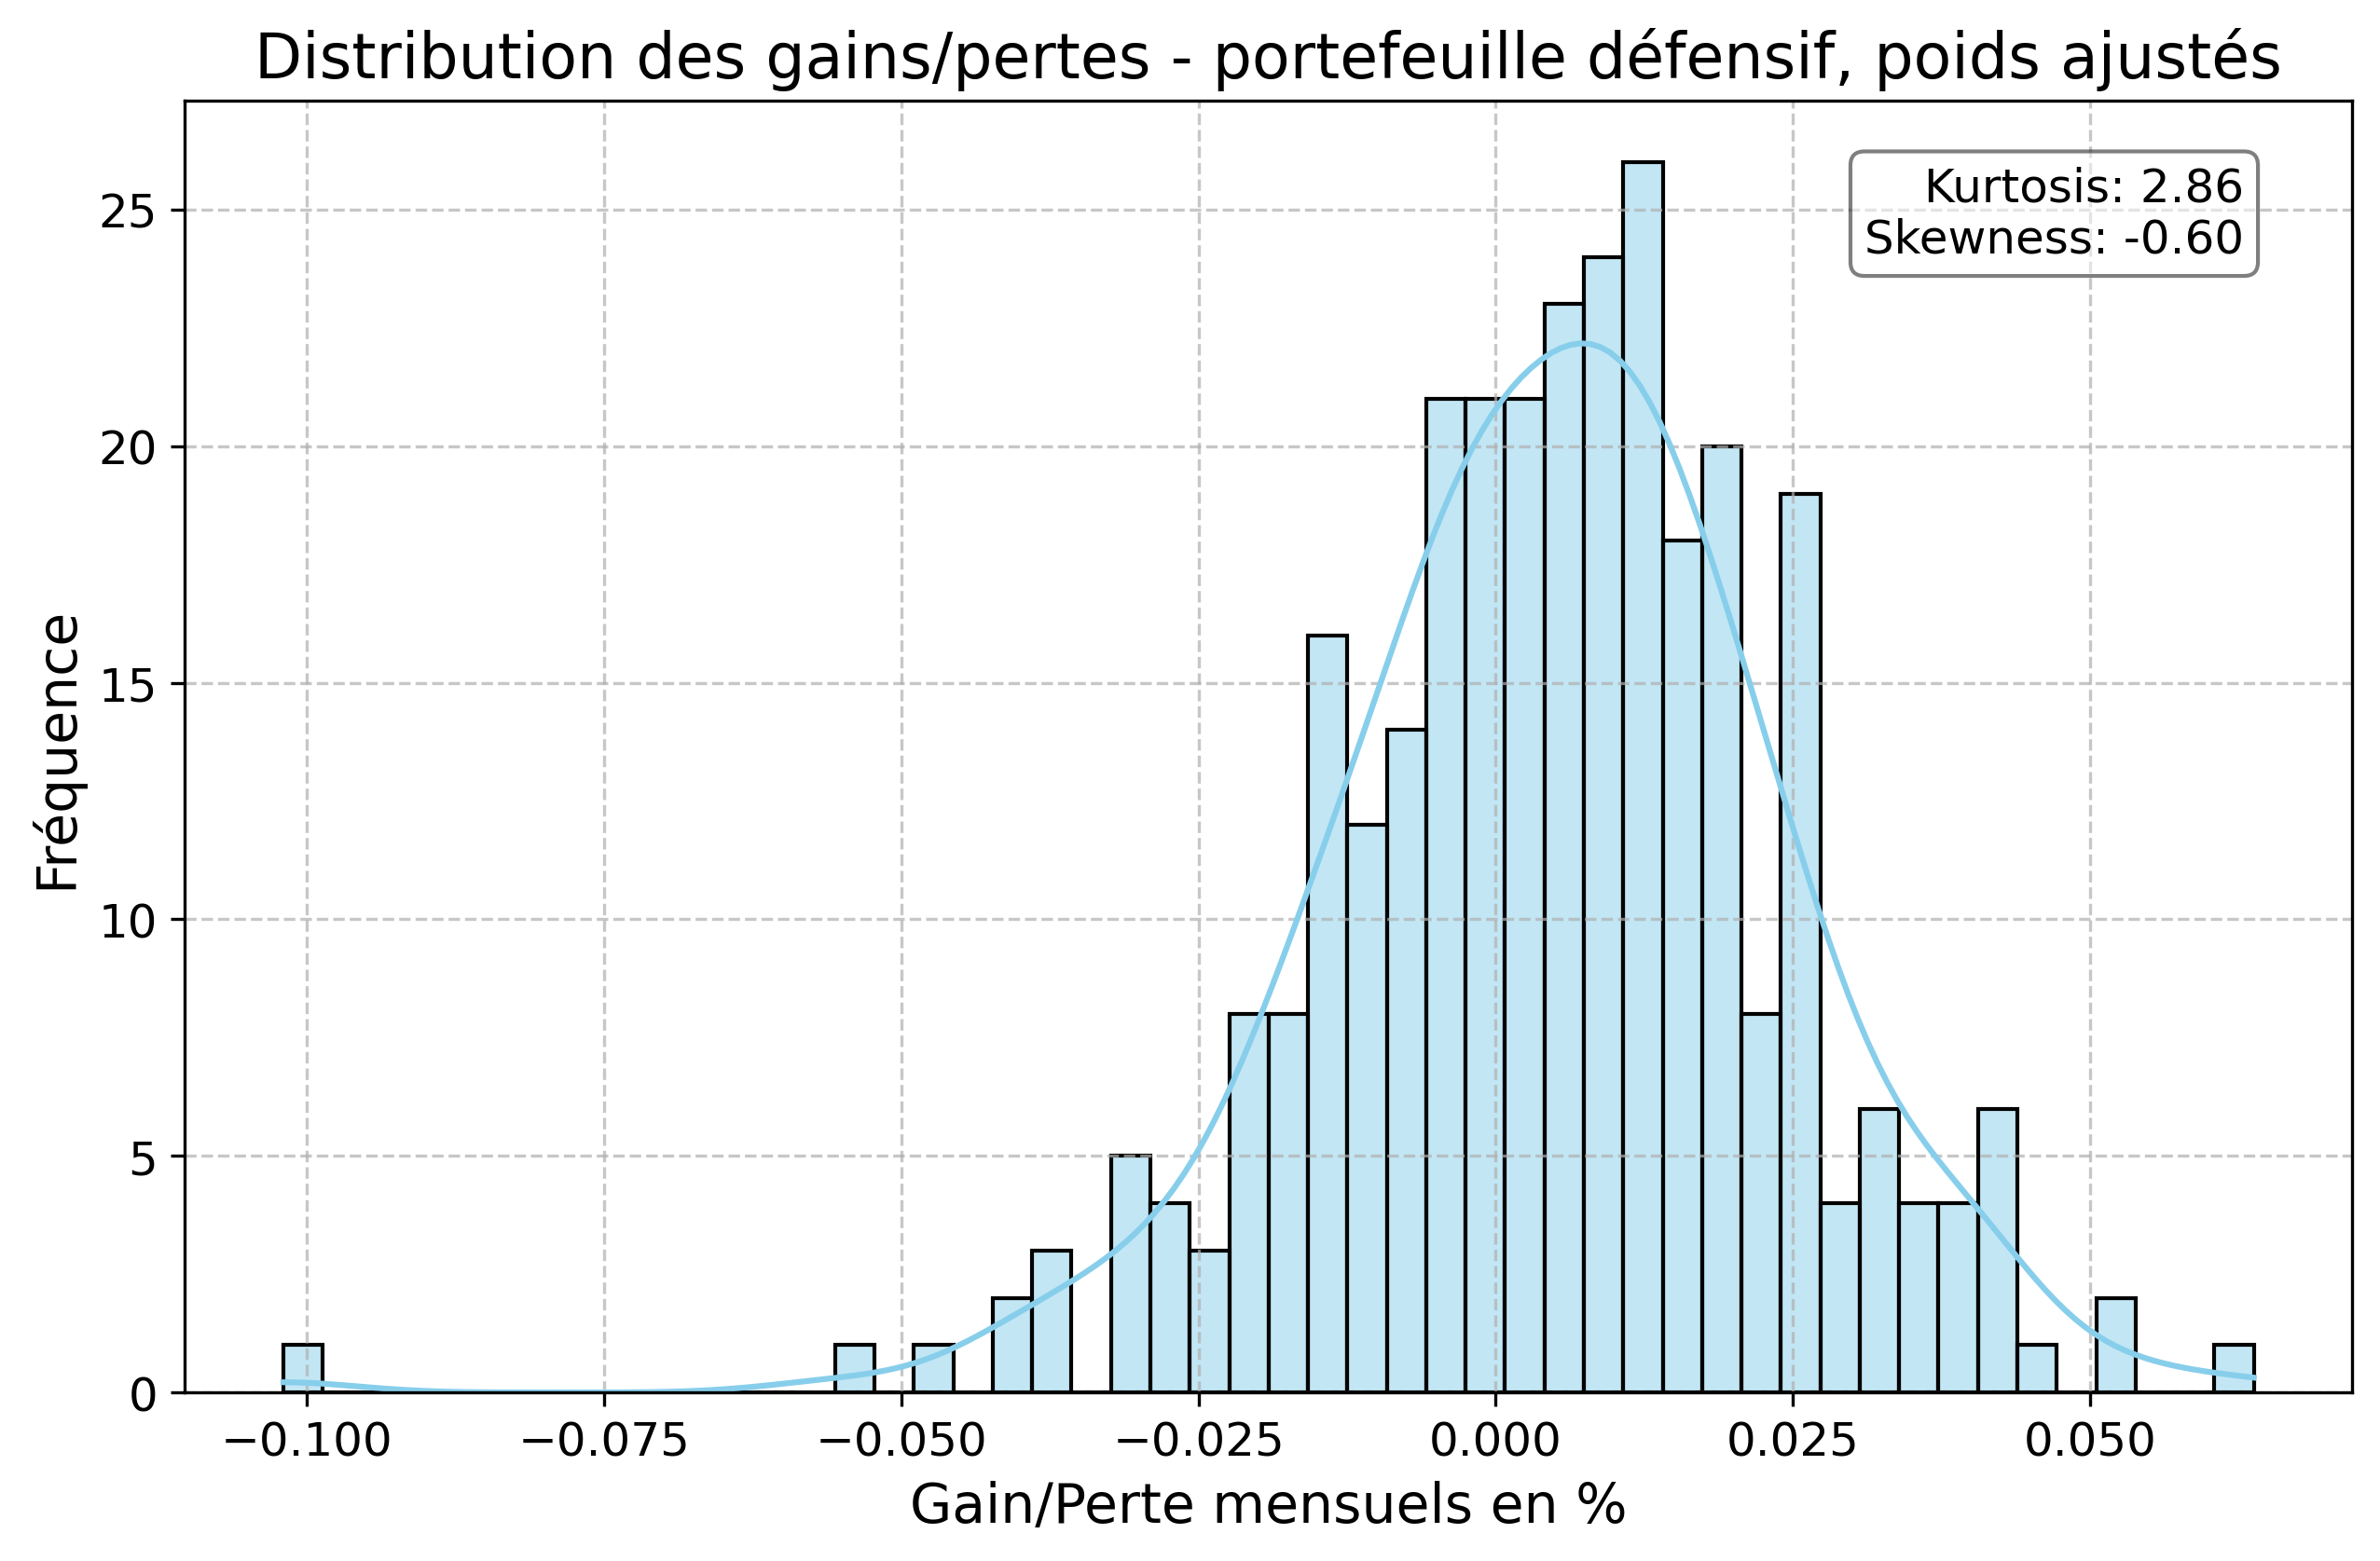

In [41]:
# Plot the histogram
plt.figure(figsize=(10, 6),  dpi=300)
sns.histplot(portfolio_returns2, bins=50, kde=True, color='skyblue', edgecolor='black')

# Calculate kurtosis and skewness
kurt = kurtosis(portfolio_returns2)
skewness = skew(portfolio_returns2)

# Add text box with kurtosis and skewness
textstr = f'Kurtosis: {kurt:.2f}\nSkewness: {skewness:.2f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.gca().text(0.95, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
               verticalalignment='top', horizontalalignment='right', bbox=props)

# Add labels and title
plt.title('Distribution des gains/pertes - portefeuille défensif, poids ajustés', fontsize=16)
plt.xlabel('Gain/Perte mensuels en %', fontsize=14)
plt.ylabel('Fréquence', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [42]:
# Parameters of the CORPORATE EU Bond ETF
yield_rate = 0.0334       # Current yield (3.33%)
duration = 4.43           # Duration in years
convexity = 22.71          # Convexity
maturity = 5.65       # Maturity in years

# Changes in yield (150 bps increase and decrease)
delta_yields = [0.015, -0.015]  # +1.5% and -1.5%

# Portfolio weights scenarios
weights = [0.2, 0.3]  # 20% and 30%

# Initialize a dictionary to store results
results = {}

for delta_y in delta_yields:
    # Calculate percentage price change using duration and convexity
    delta_p_over_p = (-duration * delta_y) + (0.5 * convexity * (delta_y ** 2))
    delta_p_over_p_percent = delta_p_over_p * 100  # Convert to percentage
    
    # Store results for each weight scenario
    for weight in weights:
        portfolio_impact = weight * delta_p_over_p_percent  # Portfolio impact in percentage
        scenario = f"Yield Change: {delta_y*100:+.1f}%, Weight: {weight*100:.0f}%"
        results[scenario] = portfolio_impact

# Display the results
print("EU Corporate Bonds Impact on Portfolio:")
for scenario, impact in results.items():
    print(f"{scenario}: {impact:.2f}%")

EU Corporate Bonds Impact on Portfolio:
Yield Change: +1.5%, Weight: 20%: -1.28%
Yield Change: +1.5%, Weight: 30%: -1.92%
Yield Change: -1.5%, Weight: 20%: 1.38%
Yield Change: -1.5%, Weight: 30%: 2.07%


In [43]:
# Parameters of the TREASURY Bills ETF
yield_rate = 0.0472       # Current yield (4.72%)
duration = 0.3          # Duration in years
convexity = 3.30          # Convexity
maturity = 0.31      # Maturity in years

# Changes in yield (150 bps increase and decrease)
delta_yields = [0.015, -0.015]  # +1.5% and -1.5%

# Portfolio weights scenarios
weights = [0.2, 0.3]  # 20% and 30%

# Initialize a dictionary to store results
results = {}

for delta_y in delta_yields:
    # Calculate percentage price change using duration and convexity
    delta_p_over_p = (-duration * delta_y) + (0.5 * convexity * (delta_y ** 2))
    delta_p_over_p_percent = delta_p_over_p * 100  # Convert to percentage
    
    # Store results for each weight scenario
    for weight in weights:
        portfolio_impact = weight * delta_p_over_p_percent  # Portfolio impact in percentage
        scenario = f"Yield Change: {delta_y*100:+.1f}%, Weight: {weight*100:.0f}%"
        results[scenario] = portfolio_impact

# Display the results
print("Treasury Bills Impact on Portfolio:")
for scenario, impact in results.items():
    print(f"{scenario}: {impact:.2f}%")

Treasury Bills Impact on Portfolio:
Yield Change: +1.5%, Weight: 20%: -0.08%
Yield Change: +1.5%, Weight: 30%: -0.12%
Yield Change: -1.5%, Weight: 20%: 0.10%
Yield Change: -1.5%, Weight: 30%: 0.15%


**END OF FILE**